### Import PySHRED

In [25]:
import numpy as np
import os
import torch
import sys
from misc.example_helper import *
import importlib
import processing
import models
%load_ext autoreload
%autoreload 2
importlib.reload(processing)
importlib.reload(models)
from processing.data_manager import SHREDDataManager
from processing.parametric_data_manager import ParametricSHREDDataManager
from models.shred_models import SHRED
from models.shred_models import evaluate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize SHREDDataManager and add datasets

In [35]:
import os

# Initialize SHREDDataManager
manager = SHREDDataManager(
    lags = 20,
    train_size = 0.7,
    val_size = 0.15,
    test_size = 0.15,
    compression=False,
    method="all"
)

file_path = "datasets/sea_surface_temperature/SST_data.npy"
manager.add(
    data=file_path,
    # random_sensors=3,
    stationary_sensors = [(46, 227),(17, 163),(134, 303)],
    id = "SST"
)

In [36]:
manager.sensor_summary

,field id,sensor id,sensor type,location/trajectory
0,SST,SST-0,stationary (user selected),"(46, 227)"
1,SST,SST-1,stationary (user selected),"(17, 163)"
2,SST,SST-2,stationary (user selected),"(134, 303)"


In [37]:
manager.sensor_measurements

,time,SST-0,SST-1,SST-2
0,0,12.29,-1.80,13.57
1,1,11.83,-1.80,14.16
2,2,11.56,-1.80,14.97
3,3,11.02,-1.80,14.54
4,4,10.69,-1.80,15.31
...,...,...,...,...
1395,1395,18.28,1.85,7.03
1396,1396,17.50,1.22,7.60
1397,1397,17.15,0.83,7.79
1398,1398,16.49,0.64,8.58


### Get train/val/test datasets

In [38]:
train_dataset, val_dataset, test_dataset = manager.preprocess()

### Initialize SHRED and fit

In [ ]:
# initialize SHRED
shred = SHRED(sequence='LSTM', decoder='SDN')
# fit SHRED
val_errors = shred.fit(train_dataset, val_dataset, num_epochs=1000)

### Evaluate SHRED on test dataset

In [40]:
evaluate(model = shred, test_dataset=test_dataset, data_manager=manager)

,SST
reconstruction,0.020912
prediction,0.046663
forecast,0.044093
sensor_forecast,0.097792


### SHRED Reconstruct

In [51]:
# SHRED Reconstruct
reconstruction = shred.reconstruct(test_dataset.reconstructor_dataset.X)
# Post-processing
dataset_dict_recon = manager.postprocess(reconstruction, method = 'reconstructor')
true_dataset_dict_recon = manager.postprocess(test_dataset.predictor_dataset.Y.cpu().numpy(),  uncompress = True, method = 'reconstructor')

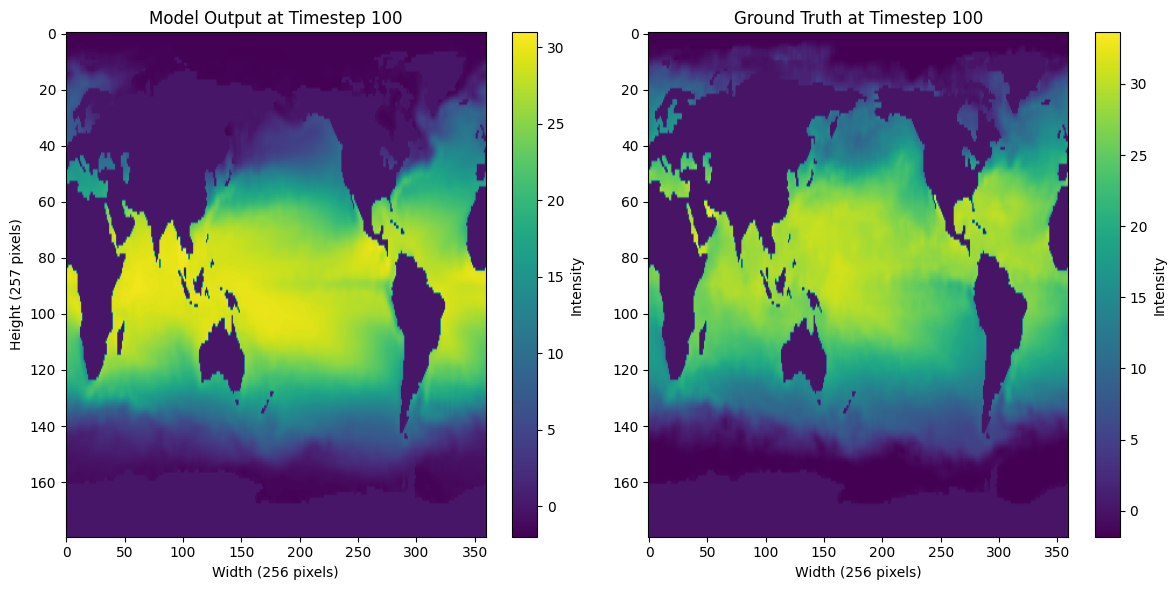

In [53]:
# plot at timestep = 100
t = 100
for key in dataset_dict_recon.keys():
    plot_frame_comparison(dataset_dict_recon[key], true_dataset_dict_recon[key], timestep=t)

### SHRED Predict

In [55]:
# SHRED Predict
prediction = shred.predict(test_dataset.predictor_dataset.X)
dataset_dict_prediction = manager.postprocess(prediction, method = 'predictor')
true_dataset_dict_prediction = manager.postprocess(test_dataset.predictor_dataset.Y.cpu().numpy(), method = 'predictor')

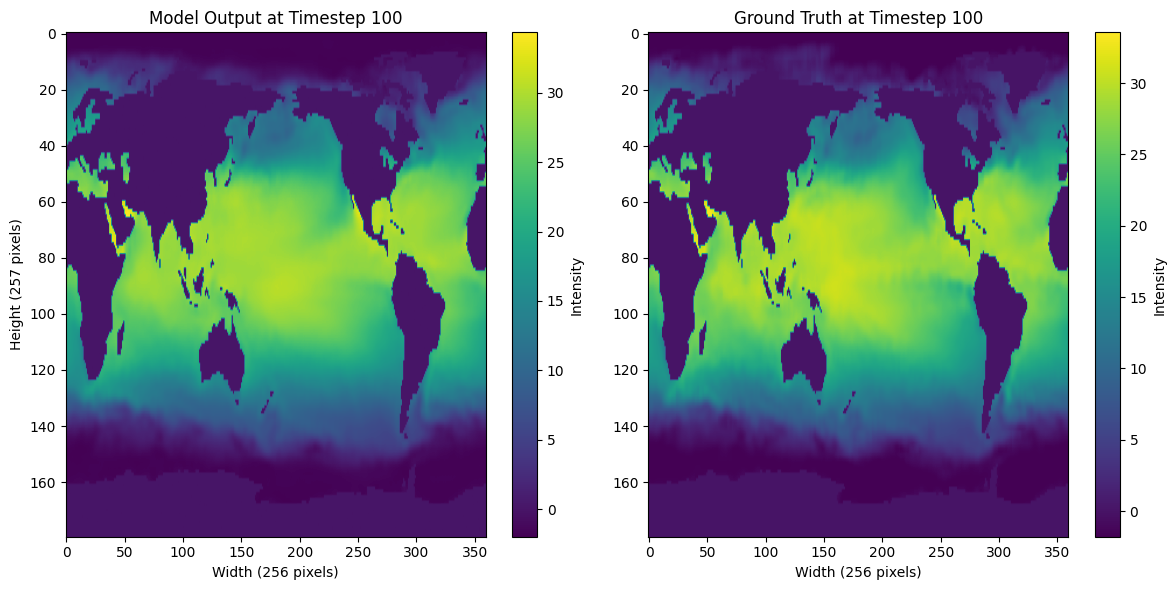

In [56]:
# plot at timestep = 100
t = 100
for key in dataset_dict_prediction.keys():
    plot_frame_comparison(dataset_dict_prediction[key], true_dataset_dict_prediction[key], timestep=t)

### SHRED Forecast

In [65]:
### Forecast Sensors
sensor_measurements_for_prediction = manager.generate_X(start = 1400, end = 1500, method = 'predictor', forecaster = shred.sensor_forecaster)
# SHRED Predict
forecast_out = shred.predict(sensor_measurements_for_prediction)
forecast_post_process = manager.postprocess(forecast_out, uncompress = True, method = 'predictor')

{0}   {3}


In [67]:
forecast_post_process['SST'].shape

(101, 180, 360)